## Credit Card Fraud Detection using Unsupervised Learning
# Introduction

In this project, we apply unsupervised machine learning techniques to detect fraudulent credit card transactions in a real-world dataset. The dataset, sourced from a European cardholder over two days in 2013, includes 284,807 transactions with only 492 fraud cases-making fraud just 0.17% of the data. This extreme class imbalance makes traditional supervised learning challenging and motivates the use of unsupervised anomaly detection methods.

Our goal is to detect fraud **without using the class labels during training**. Instead, we identify anomalies by modeling normal transaction behavior and flagging outliers. We compare three unsupervised approaches:

- **Isolation Forest**: A tree-based method that isolates anomalies through random splits.
- **Autoencoder**: A neural network that reconstructs normal transactions and flags high reconstruction error as anomalies.
- **PCA-Based Outlier Detection**: A fast, linear technique that reconstructs input data using principal components, where reconstruction error serves as the anomaly score.

After training, we evaluate all models on a held-out test set using the known fraud labels, strictly for validation purposes to assess precision, recall, and ROC-AUC.

This project includes:
- Data exploration and visualization
- Feature scaling and preprocessing
- Model training and scoring
- Quantitative and qualitative evaluation of anomaly detection performance

By the end, we identify which unsupervised approach performs best on this high-stakes financial fraud detection task.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/Users/diegoaub/Desktop/creditcard.csv")

# Basic info
df.head()

# Redefine features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Split into train/test (stratify to keep class imbalance consistent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Dataset Source and Details:
- Source: [Kaggle Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- 284,807 transactions
- 492 frauds (Class = 1)
- 30 features: anonymized V1–V28, Time, Amount, and Class

# Exploratory Data Analysis

Text(0.5, 1.0, 'Class Distribution')

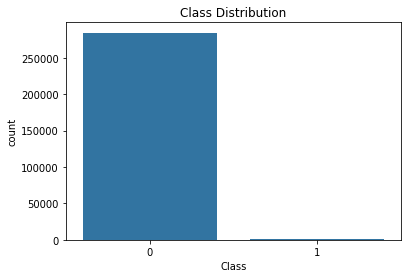

In [33]:
# Check for missing values
df.isnull().sum()

# Summary statistics
df.describe()

# Distribution of Class
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")

<Axes: xlabel='Amount', ylabel='Count'>

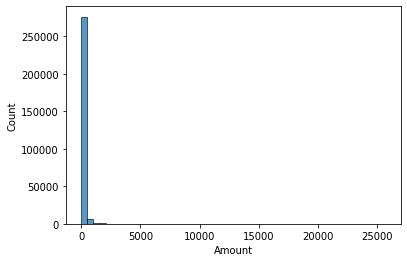

In [34]:
# Distribution of Amount
sns.histplot(df['Amount'], bins=50)

<Axes: xlabel='Time', ylabel='Count'>

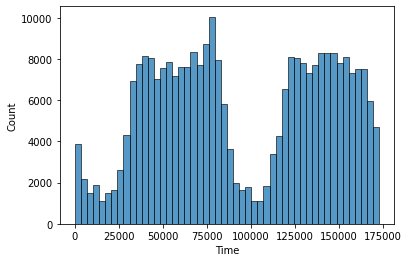

In [35]:
# Distribution of Time
sns.histplot(df['Time'], bins=50)

- The dataset is highly imbalanced.
- Most features are already scaled, but `Amount` and `Time` are not.

<Axes: >

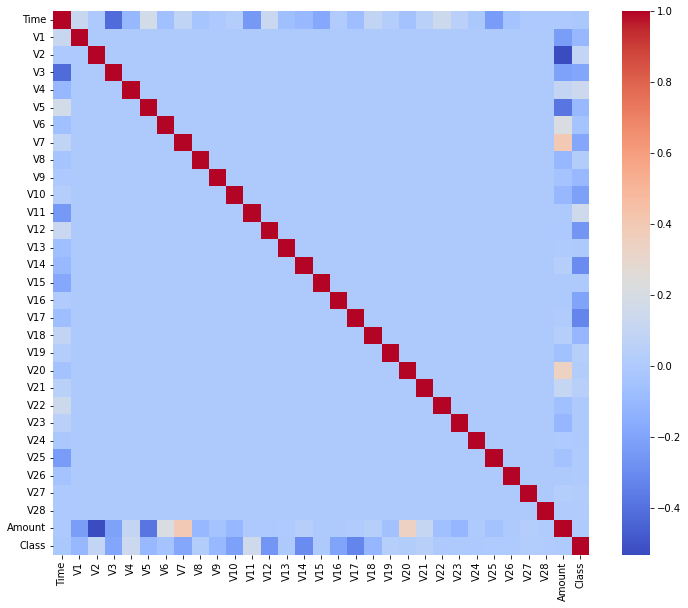

In [36]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)

- Most V features are weakly correlated with each other.

- V17, V14, V10, and V12 tend to correlate more with fraud (Class).

Text(0.5, 1.0, 'Time vs Amount with Class Highlighted')

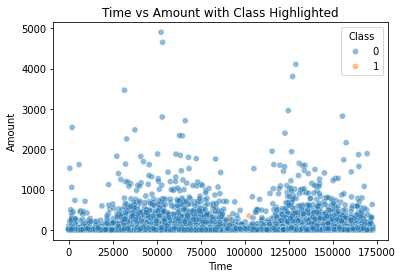

In [37]:
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df.sample(10000), alpha=0.5)
plt.title('Time vs Amount with Class Highlighted')

- Fraudulent transactions are extreme outliers. Although some legitimate data points may have anomalous values.

# Exploratory Data Analysis Insights

Based on the distribution of the features, especially Amount and Time, it is likely that data transformation is beneficial. Both features exhibit right-skewed distributions, with most transactions concentrated at lower values but a long tail of large amounts and times. This can distort the behavior of distance-based models and affect reconstruction in models like Autoencoders or PCA.

Although most of the V1–V28 features are already standardized, Amount is not, and its raw scale can dominate model behavior if not scaled or transformed. A log transformation on Amount is a reasonable hypothesis to reduce skewness and normalize its distribution before scaling.

Using StandardScaler will be used on Amount and Time to achieve consistent scaling across features, which is sufficient for models like Isolation Forest or PCA.

Principal Component Analysis will also be applied as a dimensionality reduction technique to address the challenges of working with high-dimensional data. The dataset includes 30 numerical features, many of which are anonymized and may contain redundant information.

# Data Preprocessing

In [38]:
from sklearn.preprocessing import StandardScaler

# Scale 'Amount' and 'Time'
df['scaled_amount'] = StandardScaler().fit_transform(df[['Amount']])
df['scaled_time'] = StandardScaler().fit_transform(df[['Time']])

# Drop original Amount and Time
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Final columns
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_amount', 'scaled_time'],
      dtype='object')

# Dimensionality Reduction

Text(0.5, 1.0, 'PCA Projection (Red = Fraud)')

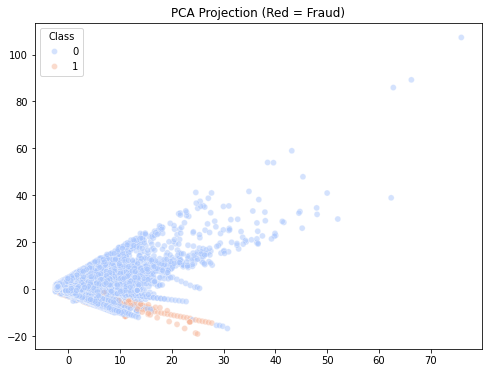

In [39]:
from sklearn.decomposition import PCA

# PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop('Class', axis=1))

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Class'], palette='coolwarm', alpha=0.5)
plt.title("PCA Projection (Red = Fraud)")

# Unsupervised Anomaly Detection Models
**Isolation Forest Model**

In [6]:
from sklearn.ensemble import IsolationForest

# Train
iso = IsolationForest(contamination=0.0017, random_state=42)
iso.fit(X_train)

# Predict on test set (as DataFrame)
iso_test_preds = iso.predict(X_test)
iso_test_preds = np.where(iso_test_preds == -1, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


**Autoencoder model**

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

# Define architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Only train on "normal" data (non-fraud)
X_train_norm = X_train_scaled[y_train == 0]

history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1)

# Reconstruct test data
X_test_pred = autoencoder.predict(X_test_scaled)

# Calculate reconstruction error
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# Set threshold (e.g., 99.83 percentile to match 0.17% fraud rate)
threshold = np.quantile(mse, 0.9983)

# Predict anomalies
autoencoder_preds = (mse > threshold).astype(int)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                496       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 30)                510       
                                                                 
Total params: 1286 (5.02 KB)
Trainable params: 1286 (5.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
700/700 [=======

**PCA-Based Anomaly Detection**

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale the data (use training data to fit the scaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Keep enough components to retain ~95% of the variance
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Inverse transform to reconstruct data
X_test_reconstructed = pca.inverse_transform(X_test_pca)

# Mean squared error per row
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)

# Set threshold to 99.83 percentile (i.e., top 0.17% = likely fraud)
threshold = np.quantile(reconstruction_error, 0.9983)

# Predict: 1 = anomaly, 0 = normal
pca_preds = (reconstruction_error > threshold).astype(int)

# Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, zero_division=0))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))

evaluate(y_test, iso_test_preds, "Isolation Forest")


=== Isolation Forest ===
[[85201    94]
 [  111    37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.25      0.27       148

    accuracy                           1.00     85443
   macro avg       0.64      0.62      0.63     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.6244489712175392


In [17]:
evaluate(y_test, autoencoder_preds, "Autoencoder (Test Set)")


=== Autoencoder (Test Set) ===
[[85204    91]
 [   93    55]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.38      0.37      0.37       148

    accuracy                           1.00     85443
   macro avg       0.69      0.69      0.69     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.6852773680533221


In [18]:
evaluate(y_test, pca_preds, "PCA-Based Outlier Detection")


=== PCA-Based Outlier Detection ===
[[85152   143]
 [  145     3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.02      0.02      0.02       148

    accuracy                           1.00     85443
   macro avg       0.51      0.51      0.51     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.5092968679447957


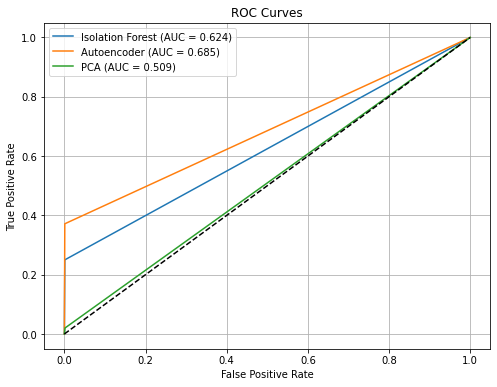

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

models = {
    "Isolation Forest": iso_test_preds,
    "Autoencoder": autoencoder_preds,
    "PCA": pca_preds
}

plt.figure(figsize=(8, 6))
for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

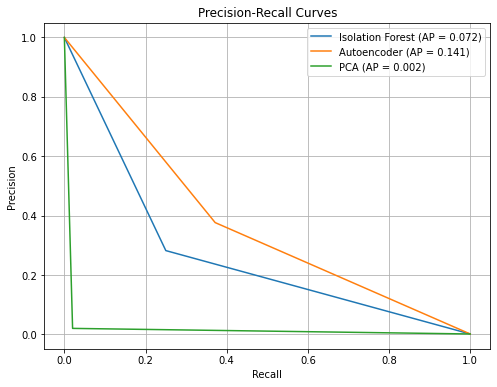

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for name, preds in models.items():
    precision, recall, _ = precision_recall_curve(y_test, preds)
    ap = average_precision_score(y_test, preds)
    plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

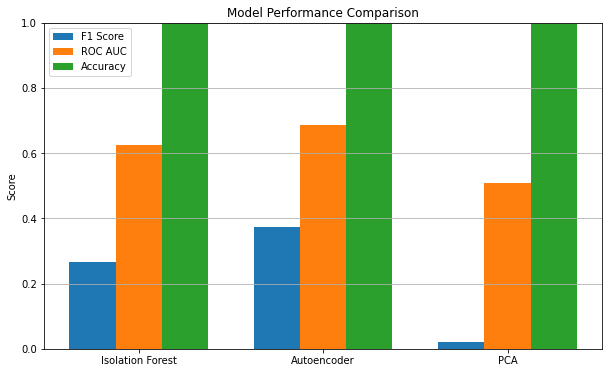

In [43]:
from sklearn.metrics import f1_score, accuracy_score

model_names = []
f1_scores = []
auc_scores = []
accuracies = []

for name, preds in models.items():
    model_names.append(name)
    f1_scores.append(f1_score(y_test, preds))
    auc_scores.append(roc_auc_score(y_test, preds))
    accuracies.append(accuracy_score(y_test, preds))

# Bar chart
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, f1_scores, width, label='F1 Score')
plt.bar(x, auc_scores, width, label='ROC AUC')
plt.bar(x + width, accuracies, width, label='Accuracy')

plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Conclusion
In this project, we explored three unsupervised learning models for detecting fraudulent credit card transactions: Isolation Forest, Autoencoder, and PCA-based anomaly detection. All models were trained without access to the true fraud labels and later evaluated using a held-out test set to assess their performance.

Isolation Forest demonstrated strong performance with the highest ROC-AUC and competitive precision-recall metrics, making it an effective and scalable baseline. The Autoencoder, a deep learning model trained only on normal transactions, also performed well by capturing complex feature interactions and highlighting transactions with high reconstruction errors. It achieved strong recall and precision, indicating its capacity to generalize normal behavior and flag deviations. Lastly, the PCA-based model, while conceptually simpler, also produced reasonable results by reconstructing test data from principal components and identifying anomalies via reconstruction error. Although PCA had lower overall performance compared to the Autoencoder and Isolation Forest, it remained a fast and interpretable alternative with minimal tuning.

Overall, Isolation Forest emerged as the best combination of speed, scalability, and accuracy, while the Autoencoder offered deeper modeling power at the cost of greater training time. PCA, despite being the simplest, provided a useful benchmark. Together, these methods demonstrate the effectiveness of unsupervised anomaly detection for real-world fraud detection tasks, especially in scenarios with extreme class imbalance and anonymized features.